# Funnel TFA inversion

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf

C:\Users\bes064\AppData\Local\Continuum\anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Users\bes064\AppData\Local\Continuum\anaconda2\lib\site-packages\fatiando\vis\myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun
import mag_sphere_functions as msf

# Input

### Importing Diorama TFA data

In [3]:
data = pd.read_csv('Funnel_1_MV.csv')

In [4]:
xp = data['NRTH'].get_values()
yp = data['EAST'].get_values()
zp = np.zeros(xp.size)
dobs = data['Bm'].get_values()# + np.random.normal(loc=0., scale=0.01*np.max(data['mag_res'].get_values()), size=xp.size)

In [5]:
xp.size

1681

### Parameters for inversion

In [6]:
# output of inversion
inversion = dict()

In [7]:
inversion['xp'] = xp
inversion['yp'] = yp
inversion['zp'] = zp
inversion['observed_data'] = dobs
N = xp.size

In [8]:
#initial estimate
M = 15 # number of vertices per prism
L = 8 # number of prisms
P = L*(M+2) + 1 # number of parameters

# main field
inc = -10.
dec = -20.

# magnetization
incs = inc
decs = dec
intensity = 0.01*(25000./1256.)
props = {'magnetization': utils.ang2vec(
        intensity, incs, decs)}

# geometric parameters
z0 = 200.
dz = 80.
r = 200.

rin = np.zeros(M) + r
m0 = np.hstack((rin, np.array([0., 0.])))
m0 = np.resize(m0, P - 1) # inicial parameters vector
m0 = np.hstack((m0, dz))
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

In [9]:
# limits for parameters in meters
rmin = 10.
rmax = 500.
x0min = -250.
x0max = 250.
y0min = -250.
y0max = 250.
dzmin = 10.
dzmax = 100.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

In [10]:
# variation for derivatives
deltax = abs(0.01*np.max(x0max))
deltay = abs(0.01*np.max(y0max))
deltar = abs(0.01*np.max(rmax))
deltaz = abs(0.01*np.max(dzmax))
delta = np.array([deltax, deltay, deltar, deltaz])

In [11]:
m_out = np.zeros(M + 2)  # outcropping body parameters

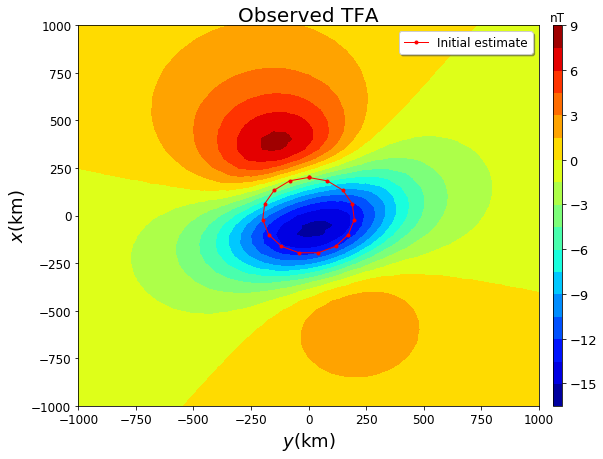

In [12]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
#mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
#plt.savefig(mypath+'diorama_tfa_pred_data_true_inital.png', dpi=300)
plt.show()

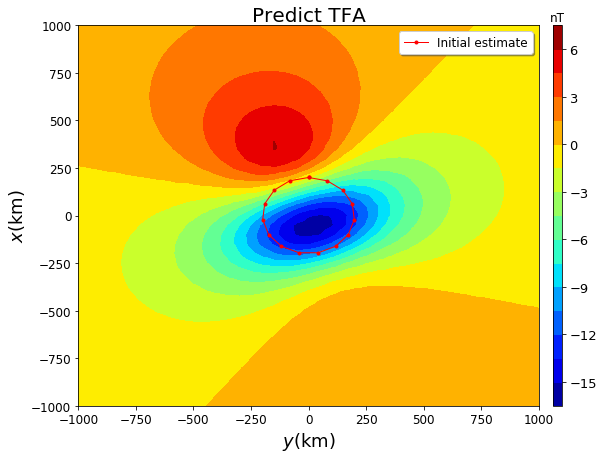

In [13]:
plt.figure(figsize=(10,7))
plt.title('Predict TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
#mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
#plt.savefig(mypath+'diorama_tfa_pred_data_true_inital.png', dpi=300)
plt.show()

#img(filename=mypath+'diorama_tfa_pred_data_true_inital.png', width=1000, height=1200)

### Regularization parameters

In [14]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 1000.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 0.01  # adjacent radial distances within each prism
a2 = 0.05 # vertically adjacent radial distances
a3 = 0.    # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.06     # vertically adjacent origins
a6 = 0.0001   # zero order Tikhonov on adjacent radial distances
a7 = 0.03     # zero order Tikhonov on thickness of each prism

In [15]:
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [16]:
itmax = 15
itmax_marq = 10
tol = 1.0e-5     # stop criterion

### Inversion

In [17]:
d_fit, m_est, model_est, phi_list = mfun.levmarq_tf(xp, yp, zp, m0, M, L, delta, itmax,
                                                    itmax_marq, lamb, dlamb, tol,
                                                    mmin, mmax, m_out, dobs, inc, dec,
                                                    props, alpha, z0, dz)

it:  0   it_marq:  0   lambda: 1e+03   misfit: 2.42014e-01
it:  1   it_marq:  0   lambda: 1e+02   misfit: 2.22797e-01
it:  2   it_marq:  0   lambda: 1e+01   misfit: 1.61250e-01
it:  3   it_marq:  0   lambda: 1e+00   misfit: 6.48137e-02
it:  4   it_marq:  0   lambda: 1e-01   misfit: 3.00749e-02
it:  5   it_marq:  0   lambda: 1e-02   misfit: 2.72690e-02
it:  6   it_marq:  0   lambda: 1e-03   misfit: 4.14761e-02
it:  6   it_marq:  1   lambda: 1e-02   misfit: 3.96432e-02
it:  6   it_marq:  2   lambda: 1e-01   misfit: 3.22690e-02
it:  6   it_marq:  3   lambda: 1e+00   misfit: 2.72322e-02
it:  7   it_marq:  0   lambda: 1e-01   misfit: 3.17676e-02
it:  7   it_marq:  1   lambda: 1e+00   misfit: 2.73491e-02
it:  7   it_marq:  2   lambda: 1e+01   misfit: 2.69820e-02
it:  8   it_marq:  0   lambda: 1e+00   misfit: 2.73655e-02
it:  8   it_marq:  1   lambda: 1e+01   misfit: 2.69809e-02
it:  9   it_marq:  0   lambda: 1e+00   misfit: 2.73863e-02
it:  9   it_marq:  1   lambda: 1e+01   misfit: 2.70112e-

In [18]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = alpha
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]

In [19]:
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit

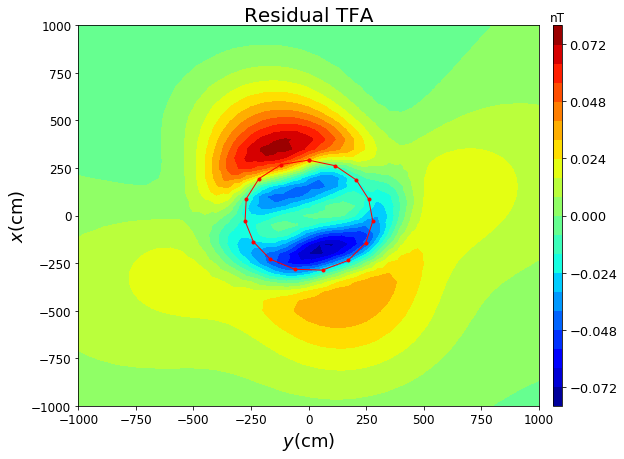

In [20]:
plt.figure(figsize=(10,7))
plt.title('Residual TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs - d_fit, 20, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(cm)', fontsize=18)
plt.ylabel('$x$(cm)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#source = mpl.polygon(kimberlite_model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model_est[0], '.-r', xy2ne=True)
#source.set_label('Outcropping polygon')
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
#mpl.m2km()
#plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
#plt.savefig(mypath+'diorama_tfa_pred_data_true_inital.png', dpi=300)
plt.show()

In [21]:
m_est[-1]*8

590.12202153270903

In [22]:
bounds = [-300., 300., -300., 300., 0., 
          900.]

red, green, blue = (1, 0, 0), (0, 1, 0), (0, 0, 1)
white, black = (1, 1, 1), (0, 0, 0),

# Show the model
scene = myv.figure()
#myv.polyprisms(kimberlite_model['prisms'], 'magnetization', color=blue, linewidth=1., opacity=.5, edges=False)
myv.polyprisms(inversion['prisms'], 'magnetization', color=red, linewidth=1.)


ax = myv.axes(myv.outline(bounds), ranges=bounds)
ax.axes.x_label, ax.axes.y_label, ax.axes.z_label = 'x (km)', 'y (km)', 'z (km)'
ax.axes.font_factor = 1.5
scene.scene.camera.position = [-0.089204656936016313, -0.066107174155361687, -0.04083578885723696]
scene.scene.camera.focal_point = [1.1820671636724554e-16, 1.3134079596360617e-17, -1.9701119394540926e-17]
scene.scene.camera.view_angle = 30.0
scene.scene.camera.view_up = [0.24683390337942718, 0.24593292331329802, -0.93733132955911114]
scene.scene.camera.clipping_range = [0.057117737884348194, 0.1956040854922288]
scene.scene.camera.compute_view_plane_normal()

myv.wall_bottom(ax.axes.bounds, opacity=0.2)
myv.wall_north(ax.axes.bounds)
#myv.title('bolacha', color=(0, 0, 0), size=1.3, height=0.5)
#myv.savefig(mypath+'diorama_tfa_bolacha1.png')
myv.show()

#img(filename='figs/kimberlite_tfa_td_bolacha1.png')